# Tensorflow 2 Object Detection API
Tensorflow 2에 있는 Object Detection API를 설치하기 위해 Tensorflow-garden을 설치해준다.  
[Tutorial](https://github.com/tensorflow/models/blob/master/research/object_detection/colab_tutorials/object_detection_tutorial.ipynb)  
[Tutorial 2](https://tensorflow-object-detection-api-tutorial.readthedocs.io/en/2.2.0/index.html)  
[Install Guide](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/tf2.md)

Tensorflow requires `protobuf<=3.19.6`, but this version doesn't have `builder.py`.  
So before import object_detection in Tensorflow 2 Garden, install `protobuf==3.20.3` and copy `builder.py` to other directory, paste back to original directory after install protobuf==3.19.6

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
COLAB_PATH = '/content/drive/MyDrive/AI_Bootcamp/Section_4/proj/'

In [ ]:
!pip install protobuf==3.20.3
!cp /usr/local/lib/python3.8/dist-packages/google/protobuf/internal/builder.py .
!pip install protobuf==3.19.6
!cp builder.py /usr/local/lib/python3.8/dist-packages/google/protobuf/internal/

Even copy `builder.py` from other version of protobuf, import `label_map_util` still makes error. It saids "cannot import name 'string_int_label_map_pb2' from 'object_detection.protos'".

In [5]:
# !wget https://raw.githubusercontent.com/datitran/object_detector_app/master/object_detection/protos/string_int_label_map_pb2.py

In [ ]:
!pip install tf_slim

## Download Tensorflow Garden

In [7]:
import os
import pathlib

if "models" in pathlib.Path.cwd().parts:
    while "models" in pathlib.Path.cwd().parts:
        os.chdir('..')
elif not pathlib.Path('models').exists():
    !git clone --depth 1 https://github.com/tensorflow/models

In [8]:
# Change Font to DejavuSans, increase font size in object-detector visualization_utils
import re

with open('models/research/object_detection/utils/visualization_utils.py') as f:
    temp = f.read()
    
temp = re.sub("(\'arial.ttf\', 24)", f"\'{COLAB_PATH}DejaVuSans.ttf\', 12", temp)
with open('models/research/object_detection/utils/visualization_utils.py', 'w') as f:
    f.write(temp)

## Compile Protobuf, Install Object Detection Package

In [This tutorial](https://github.com/tensorflow/models/blob/master/research/object_detection/colab_tutorials/object_detection_tutorial.ipynb), they just pip install everyting in `models/research`.  
But this occurs error in this version that there is no `setup.py` in this directotry. Copy setup.py from `models/research/object_detection/packages/tf2/` to `models/research` and then run pip install.

In [ ]:
%%bash
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install .

Test Installation

In [10]:
# %%bash
# cd models/research
# python object_detection/builders/model_builder_tf2_test.py

## Prepare Workspace
```
/content/
├─ ...COLAB_PATH/
│   ├─ tfrecords/
│   │   ├─ *.tfrecord
│   │   ├─ test_png
│   │   ├─ dicom_params.json
│   │   ├─ label_map.pbtxt
│   │   └─ train_wbf_fold.csv
│   │
│   ├─ training/
│   │   ├─ checkpoint
│   │   ├─ ckpt-*
│   │   └─ pipeline.config
│   │
│   ├─ train.csv
│   ├─ sample_submission.csv
│   └─ test_png/
│
------ temporary ------
│
├─ models/   ### reload necesarry ### Object Detection API
│   ├─ official
│   ├─ research
│   ├─ tensorflow_models
│   └─ ...
│
├─ pre_trained_models/
│   └─ efficientdet_d0_coco17_tpu-32/
│        ├─ checkpoint
│        ├─ saved_model
│        └─ pipeline.config
│
└─ training/  
     ├─ checkpoint
     ├─ ckpt-*
     └─ pipeline.config

```

In [11]:
# 디렉토리 생성
os.makedirs('pre_trained_models', exist_ok=True) # 사전학습 모델
os.makedirs('training', exist_ok=True) # 훈련 후 저장

# Download Pretrained Model
[Detection Model Zoo](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/tf2_detection_zoo.md)

모델은 EfficientDet D0를 사용한다.  

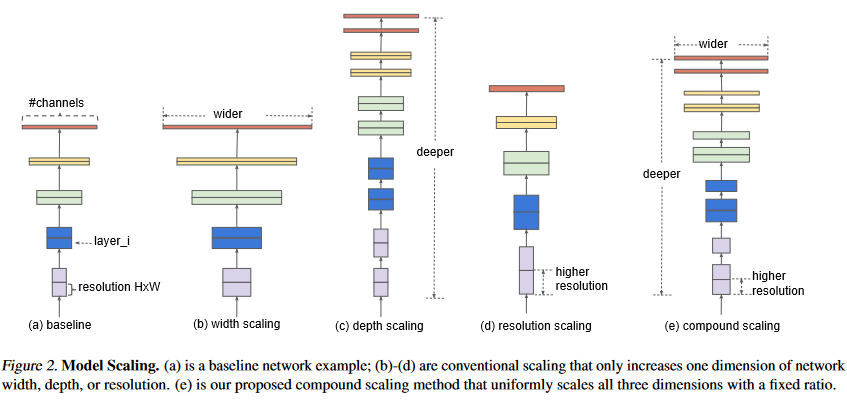

EfficientDet는 EfficientNet을 Backbone으로 하는 객체 탐지 모델이다.  
컴퓨터 비전 영역에서 모델의 효율성이 점점 증가하고 있어 적은 파라미터와 연산으로도 좋은 성능을 내는 모델을 필요로 하고있다. EfficientNet은 이런 모델의 효율성에 더해 모델을 간단히 스케일링 하는 것으로 작은 모델부터 큰 모델까지 적용할 수 있도록 만들어져있다. 다른 모델에서처럼 하나의 모델 특성만 조절하는 것이 아니라 세 특성을 동시에 고정된 비율로 조절해준다.  
이런 방식을 Detection model에도 동일하게 적용해준 것이 EfficientDet이다.

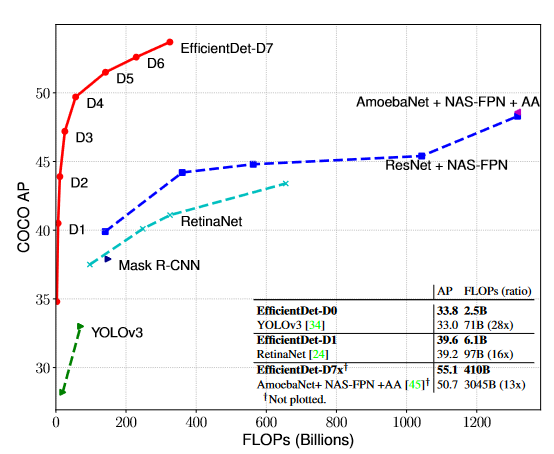

이 모델이 나왔을 때 EfficientDet은 가장 스케일을 크게 했을 때 COCO 데이터셋에서 Average Precision 점수가 55.1%로 이전의 모델들보다 높은 점수를 기록했다. 파라미터의 수도 그래프에 있는 아메바 넷에 NAS FPN을 사용한 모델과 비슷한 점수인 D4와 비교했을 때 약 8.8배 적었고 연산량도 24배 적다. 자세한 비교는 [논문](https://arxiv.org/abs/1911.09070)에 나와있다.  

모델을 설계할 때 두가지를 중점적으로 봤다고 한다. 먼저 하나는 다양한 스케일의 특성들을 활용한 [Feature Pyramid Network (FPN)](https://arxiv.org/abs/1612.03144)의 구조를 더 발전시킨 BiFPN을 사용한 것이다. 

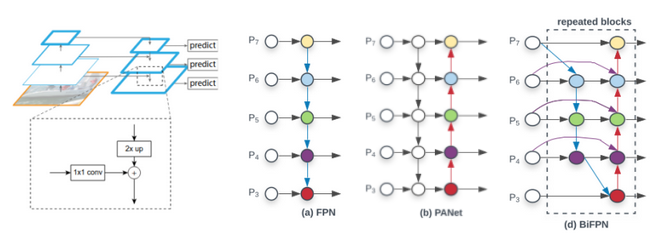

FPN 구조를 보면 $P_3$에서 $P_7$까지 각 층의 출력을 가져오고, Top-down 경로로 다양한 스케일의 특성을 넘겨준다. 그 과정에서 skip 구조를 만들어 손실된 정보들을 보충해준다.  
BiFPN은 기본 FPN 구조에서 bottom-up 구조를 추가한 PANet을 수정했다. PANet에서 입력이 하나만 있는 노드를 제거하고 입력($P_3$ ~ $P_7$)에서 bottom-up 구조에 새 경로를 추가해 많은 연산 비용을 들이지 않고 더 많은 특성을 추가 할 수 있도록 했다. 그리고 이 구조를 하나의 레이어처럼 사용해 여러개를 반복해서 사용했다. 전체적인 구조는 다음 사진과 같다.

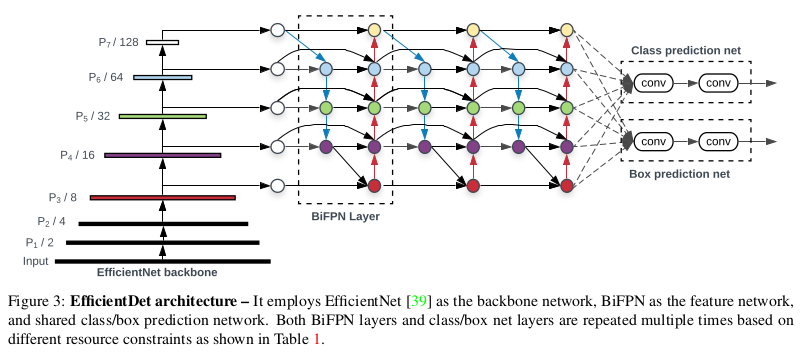

두 번째는 다른 모델들의 스케일링과 달리 compound scaling으로 깊이, 너비(채널 수 ), 해상도 모두를 동시에 스케일링하여 다양한 자원 환경에서 더 높은 효율을 낼 수 있도록 만들어주었다.

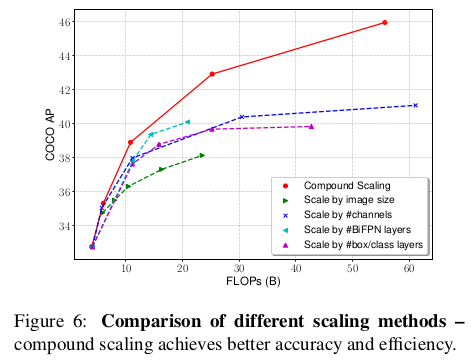

In [12]:
PRETRAINED_MODEL = "efficientdet_d0_coco17_tpu-32"
PRETRAINED_PATH = './pre_trained_models/' + PRETRAINED_MODEL 

!wget http://download.tensorflow.org/models/object_detection/tf2/20200711/{PRETRAINED_MODEL}.tar.gz
!tar -xvzf {PRETRAINED_MODEL}.tar.gz

# remove tar.gz, move directory
!rm -rf {PRETRAINED_MODEL}.tar.gz
!mv {PRETRAINED_MODEL} {PRETRAINED_PATH}

--2022-12-05 04:00:30--  http://download.tensorflow.org/models/object_detection/tf2/20200711/efficientdet_d0_coco17_tpu-32.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 142.250.136.128, 2607:f8b0:4001:c34::80
Connecting to download.tensorflow.org (download.tensorflow.org)|142.250.136.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30736482 (29M) [application/x-tar]
Saving to: ‘efficientdet_d0_coco17_tpu-32.tar.gz’

efficientdet_d0_coc 100%[===================>]  29.31M  --.-KB/s    in 0.1s    

2022-12-05 04:00:31 (233 MB/s) - ‘efficientdet_d0_coco17_tpu-32.tar.gz’ saved [30736482/30736482]

efficientdet_d0_coco17_tpu-32/
efficientdet_d0_coco17_tpu-32/checkpoint/
efficientdet_d0_coco17_tpu-32/checkpoint/ckpt-0.data-00000-of-00001
efficientdet_d0_coco17_tpu-32/checkpoint/checkpoint
efficientdet_d0_coco17_tpu-32/checkpoint/ckpt-0.index
efficientdet_d0_coco17_tpu-32/pipeline.config
efficientdet_d0_coco17_tpu-32/saved_model/
efficientdet

# Import

In [ ]:
!pip install ensemble-boxes

In [14]:
import cv2
from IPython.display import display
from PIL import Image
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import tensorflow as tf

from ensemble_boxes import *
from object_detection.utils import ops as utils_ops
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util
from object_detection.utils import config_util
from object_detection.builders import model_builder

%matplotlib inline

In [ ]:
# Load model
MODEL_PATH = os.path.join(PRETRAINED_PATH, 'saved_model')
model = tf.saved_model.load(str(MODEL_PATH))

<a name='dataset'></a>
# Dataset

Read TFRecord files using tf.io.parse_single_example  

In [16]:
# Load Dataset
DATA_PATH = COLAB_PATH + 'tfrecords/'
VALID_DATASET = tf.io.gfile.glob(DATA_PATH + 'Xray_abnormalities_01_of_05.tfrecord')
TRAIN_DATASET = tf.io.gfile.glob(DATA_PATH + 'Xray_abnormalities_0[^1]_of_05.tfrecord')

# Set labels
LABELS_PATH = COLAB_PATH + 'tfrecords/label_map.pbtxt'
category_index = label_map_util.create_category_index_from_labelmap(
    LABELS_PATH, use_display_name=True)

sample_dataset = TRAIN_DATASET[0]

In [17]:
# https://www.tensorflow.org/tutorials/load_data/tfrecord#read_the_tfrecord_file
# Create a dictionary describing the features.
image_feature_description = {
    'image/height': tf.io.FixedLenFeature([], tf.int64),
    'image/width': tf.io.FixedLenFeature([], tf.int64),
    'image/filename': tf.io.FixedLenFeature([], tf.string),
    'image/source_id': tf.io.FixedLenFeature([], tf.string),
    'image/encoded': tf.io.FixedLenFeature([], tf.string),
    'image/format': tf.io.FixedLenFeature([], tf.string),
    'image/object/bbox/xmin': tf.io.FixedLenSequenceFeature([], tf.float32, True),
    'image/object/bbox/xmax': tf.io.FixedLenSequenceFeature([], tf.float32, True),
    'image/object/bbox/ymin': tf.io.FixedLenSequenceFeature([], tf.float32, True),
    'image/object/bbox/ymax': tf.io.FixedLenSequenceFeature([], tf.float32, True),
    'image/object/class/text': tf.io.FixedLenSequenceFeature([], tf.string, True),
    'image/object/class/label': tf.io.FixedLenSequenceFeature([], tf.int64, True)
}

def _parse_image_function(example_proto):
    # Parse the input tf.train.Example proto using the dictionary above.
    return tf.io.parse_single_example(example_proto, image_feature_description)

raw_image_dataset = tf.data.TFRecordDataset(sample_dataset)

parsed_image_dataset = raw_image_dataset.map(_parse_image_function)
parsed_image_dataset

<MapDataset element_spec={'image/encoded': TensorSpec(shape=(), dtype=tf.string, name=None), 'image/filename': TensorSpec(shape=(), dtype=tf.string, name=None), 'image/format': TensorSpec(shape=(), dtype=tf.string, name=None), 'image/height': TensorSpec(shape=(), dtype=tf.int64, name=None), 'image/object/bbox/xmax': TensorSpec(shape=(None,), dtype=tf.float32, name=None), 'image/object/bbox/xmin': TensorSpec(shape=(None,), dtype=tf.float32, name=None), 'image/object/bbox/ymax': TensorSpec(shape=(None,), dtype=tf.float32, name=None), 'image/object/bbox/ymin': TensorSpec(shape=(None,), dtype=tf.float32, name=None), 'image/object/class/label': TensorSpec(shape=(None,), dtype=tf.int64, name=None), 'image/object/class/text': TensorSpec(shape=(None,), dtype=tf.string, name=None), 'image/source_id': TensorSpec(shape=(), dtype=tf.string, name=None), 'image/width': TensorSpec(shape=(), dtype=tf.int64, name=None)}>

<a name='plot'></a>
## Show Samples

In [18]:
def sample_record_to_image(N, M):
    samples = list(parsed_image_dataset)[N:M]
    images = []
    for sample in samples:
        image_dict = {}
        image_encoded = sample['image/encoded']
        image_np = tf.image.decode_png(image_encoded).numpy()
        image_dict['image_arr'] = cv2.cvtColor(image_np, cv2.COLOR_GRAY2RGB)

        image_dict['classes'] = sample['image/object/class/label'].numpy()
        image_dict['boxes'] = np.stack([sample['image/object/bbox/ymin'],
                          sample['image/object/bbox/xmin'],
                          sample['image/object/bbox/ymax'],
                          sample['image/object/bbox/xmax']], axis=-1)
        images.append(image_dict)
    return images

In [19]:
def get_image_with_boxes(image_arr, boxes, classes, scores=None):
    if scores is None:
        scores = np.ones(len(classes))

    image_bbox = image_arr.copy()

    vis_util.visualize_boxes_and_labels_on_image_array(
        image_bbox,
        boxes,
        classes,
        scores,
        category_index,
        use_normalized_coordinates=True,
        max_boxes_to_draw=200,
        min_score_thresh=0.2,
        agnostic_mode=False
    )

    return image_bbox

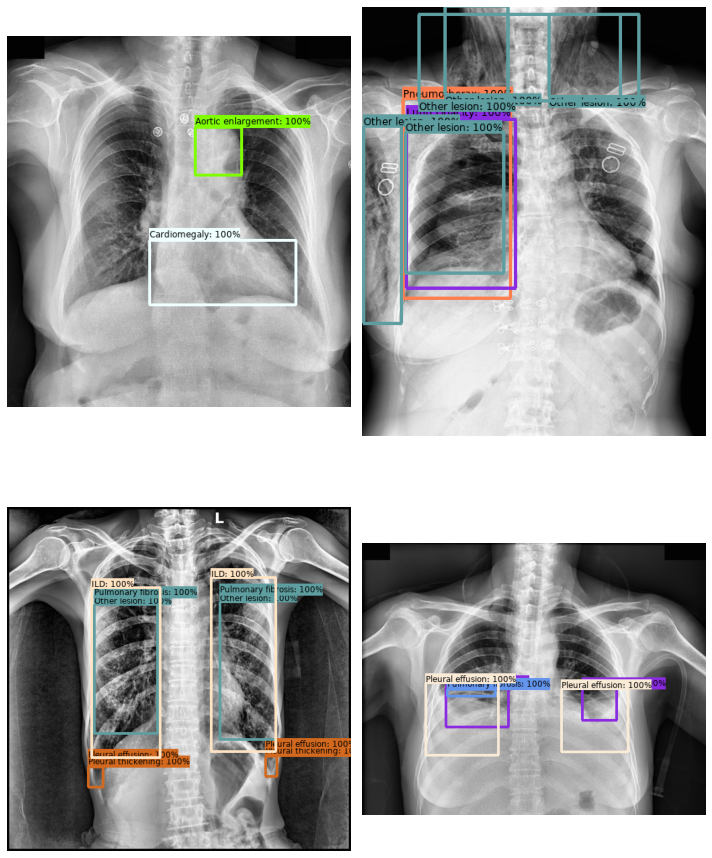

In [20]:
N = 4
M = 9
plt.figure(figsize=(10, 14))

sample_images = sample_record_to_image(N, M)
for i in range(N):
    sample_image = get_image_with_boxes(**sample_images[i])
    plt.subplot((N-1)//2+1, 2, i+1)
    plt.imshow(sample_image)
    plt.axis('off')
plt.tight_layout()
plt.show()

# Model Configuration

In [21]:
train_wbf = pd.read_csv(COLAB_PATH + 'tfrecords/train_wbf_fold.csv')

In [22]:
# Training Parameters
EPOCHS = 5
BATCH_SIZE = 4
NUM_TRAIN_STEPS = len(train_wbf[train_wbf['group']!=0]['image_id'].unique())//BATCH_SIZE * EPOCHS
NUM_EVAL_STEPS = len(train_wbf[train_wbf['group']==0]['image_id'].unique())//BATCH_SIZE * EPOCHS

In [23]:
CONFIG_PATH = PRETRAINED_PATH + '/pipeline.config'

config = config_util.get_configs_from_pipeline_file(CONFIG_PATH)
config.keys()

dict_keys(['model', 'train_config', 'train_input_config', 'eval_config', 'eval_input_configs', 'eval_input_config'])

In [24]:
config['model'].ssd.num_classes = 14

config['train_config'].batch_size = BATCH_SIZE
config['train_config'].fine_tune_checkpoint = f"{PRETRAINED_PATH}/checkpoint/ckpt-0"
config['train_config'].fine_tune_checkpoint_type = 'detection'

# config['eval_config'].metrics_set[:] = ''
# config['eval_config'].metrics_set.append('pascal_voc_detection')

config['train_input_config'].label_map_path = LABELS_PATH
config['train_input_config'].tf_record_input_reader.input_path[:] = TRAIN_DATASET

config['eval_input_config'].label_map_path = LABELS_PATH
config['eval_input_config'].tf_record_input_reader.input_path[:] = VALID_DATASET

config_util.save_pipeline_config(config_util.create_pipeline_proto_from_configs(config),
                                 './training')

# Train Model

[Tutorial](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/tf2_training_and_evaluation.md)

In [25]:
!python /content/models/research/object_detection/model_main_tf2.py \
    --pipeline_config_path='./training/pipeline.config' \
    --model_dir='./training' \
    --num_train_steps=3500 \
    --num_eval_steps=1500 \
    --alsologtostderr

2022-12-05 04:01:08.232965: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2022-12-05 04:01:08.233079: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2022-12-05 04:01:08.233098: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.
/usr/local/lib/python3.8/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow ver

# Evaluation

In [26]:
!python /content/models/research/object_detection/model_main_tf2.py \
     --pipeline_config_path='./training/pipeline.config' \
     --model_dir='./training' \
     --checkpoint_dir='./training' \
     --run_once=True

2022-12-05 04:16:32.850297: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2022-12-05 04:16:32.850475: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2022-12-05 04:16:32.850495: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.
/usr/local/lib/python3.8/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow ver

In [27]:
# Copy training data to colab to use checkpoint after restart runtime
!cp -R training {COLAB_PATH}

---  
---

# Load

In [28]:
from google.colab import drive
drive.mount('/content/drive')

COLAB_PATH = '/content/drive/MyDrive/AI_Bootcamp/Section_4/proj/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Reload

In [ ]:
!pip install protobuf==3.20.3
!cp /usr/local/lib/python3.8/dist-packages/google/protobuf/internal/builder.py .
!pip install protobuf==3.19.6
!cp builder.py /usr/local/lib/python3.8/dist-packages/google/protobuf/internal/

!pip install tf_slim

In [30]:
import os
import pathlib

if "models" in pathlib.Path.cwd().parts:
    while "models" in pathlib.Path.cwd().parts:
        os.chdir('..')
elif not pathlib.Path('models').exists():
    !git clone --depth 1 https://github.com/tensorflow/models

In [31]:
# Change Font to DejavuSans, increase font size in object-detector visualization_utils
import re
vis_path = 'models/research/object_detection/utils/visualization_utils.py'

with open(vis_path) as f:
    temp = f.read()
    
temp = re.sub("(\'arial.ttf\', 24)", f"\'{COLAB_PATH}DejaVuSans.ttf\', 12", temp)
with open(vis_path, 'w') as f:
    f.write(temp)

In [ ]:
%%bash
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install .

In [33]:
!pip install ensemble-boxes

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [34]:
import cv2
from IPython.display import display
from PIL import Image
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import tensorflow as tf
from ensemble_boxes import *

from object_detection.utils import ops as utils_ops
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util
from object_detection.utils import config_util
from object_detection.builders import model_builder

%matplotlib inline

## Build model
[Tutorial](https://tensorflow-object-detection-api-tutorial.readthedocs.io/en/latest/auto_examples/plot_object_detection_checkpoint.html#load-the-model)

In [35]:
# Path
TRAINED_PATH = COLAB_PATH + 'training/'
CONFIG_PATH = TRAINED_PATH + 'pipeline.config'

In [36]:
# Config
config = config_util.get_configs_from_pipeline_file(CONFIG_PATH)

# Model
model_config = config['model']
detection_model = model_builder.build(model_config=model_config, is_training=False)

In [37]:
# Checkpoint
last_ckpt = pathlib.Path(sorted(tf.io.gfile.glob(TRAINED_PATH + 'ckpt*'))[-1]).stem

ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(TRAINED_PATH, last_ckpt)).expect_partial()

In [38]:
# Detect function
@tf.function(experimental_relax_shapes=True) # To prevent retracing, pass experimental_relax_shapes=True
def detect_fn(image):
    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)
    return detections, prediction_dict, tf.reshape(shapes, [-1])

In [39]:
# Label
LABEL_PATH = config['eval_input_config'].label_map_path
category_index = label_map_util.create_category_index_from_labelmap(
    LABEL_PATH, use_display_name=True)

# Predict

## Sample

Reload [dataset example](#dataset) and [plot function](#plot) to evaluate model and show results  
[Tutorial](https://github.com/tensorflow/models/blob/master/research/object_detection/colab_tutorials/inference_tf2_colab.ipynb)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


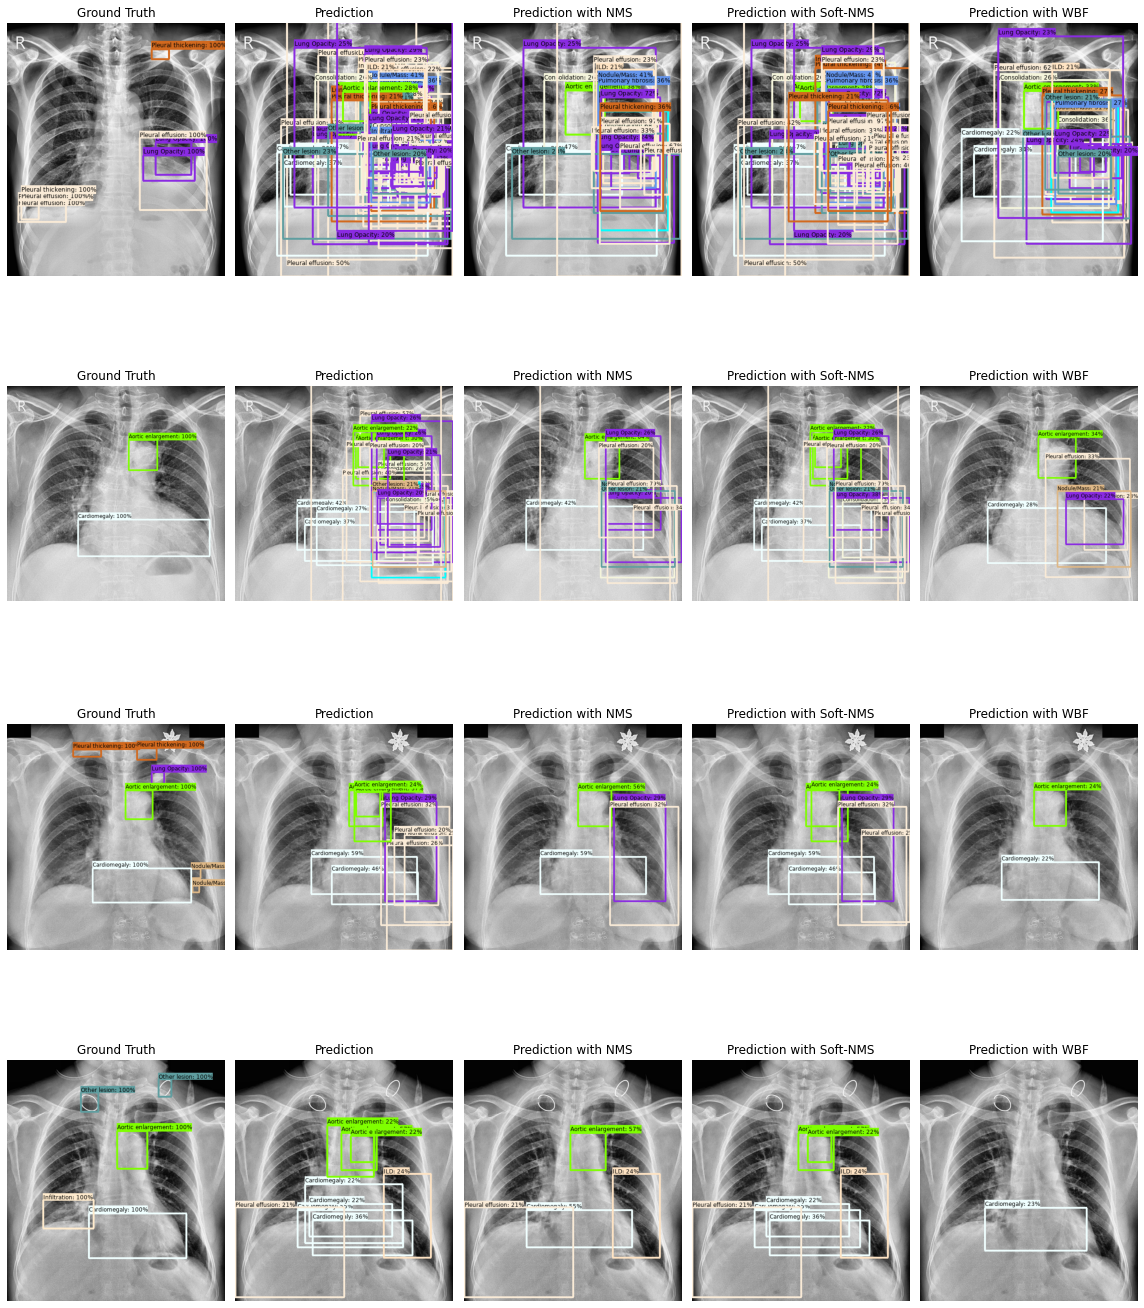

In [40]:
N = 8
M = 12
label_id_offset = 1

iou_thr = 0.30
skip_box_thr = 0.0001
sigma = 0.1

plt.figure(figsize=(16, (M-N)*5))

sample_images = sample_record_to_image(N, M)
for i in range(M-N):
    image = sample_images[i]['image_arr']
    image_tensor = tf.convert_to_tensor(np.expand_dims(image, 0), dtype=tf.float32)
    
    detections, predictions_dict, shapes = detect_fn(image_tensor)

    boxes_nms, scores_nms, labels_nms = nms([detections['detection_boxes'][0].numpy()],
                                                          [detections['detection_scores'][0].numpy()],
                                                          [(detections['detection_classes'][0].numpy()+label_id_offset).astype(int)],
                                                          weights=None,
                                                          iou_thr=iou_thr)
    
    boxes_softnms, scores_softnms, labels_softnms = soft_nms([detections['detection_boxes'][0].numpy()],
                                                          [detections['detection_scores'][0].numpy()],
                                                          [(detections['detection_classes'][0].numpy()+label_id_offset).astype(int)],
                                                          weights=None,
                                                          iou_thr=iou_thr,
                                                          sigma=sigma,
                                                          thresh=skip_box_thr)

    boxes_wbf, scores_wbf, labels_wbf = weighted_boxes_fusion([detections['detection_boxes'][0].numpy()],
                                                          [detections['detection_scores'][0].numpy()],
                                                          [(detections['detection_classes'][0].numpy()+label_id_offset).astype(int)],
                                                          weights=None,
                                                          iou_thr=iou_thr,
                                                          skip_box_thr=skip_box_thr)
    
    image_true = get_image_with_boxes(**sample_images[i])
    image_pred = get_image_with_boxes(image, 
                                      detections['detection_boxes'][0].numpy(),
                                      (detections['detection_classes'][0].numpy()+label_id_offset).astype(int),
                                      detections['detection_scores'][0].numpy()
                                     )
    image_nms = get_image_with_boxes(image, 
                                      boxes_nms,
                                      labels_nms.astype(int),
                                      scores_nms
                                     )
    image_softnms = get_image_with_boxes(image, 
                                      boxes_softnms,
                                      labels_softnms.astype(int),
                                      scores_softnms
                                     )
    image_wbf = get_image_with_boxes(image, 
                                      boxes_wbf,
                                      labels_wbf.astype(int),
                                      scores_wbf
                                     )
    
    plt.subplot(M-N, 5, i*5+1)
    plt.imshow(image_true)
    plt.axis('off')
    plt.title('Ground Truth')
    plt.subplot(M-N, 5, i*5+2)
    plt.imshow(image_pred)
    plt.axis('off')
    plt.title("Prediction")
    plt.subplot(M-N, 5, i*5+3)
    plt.imshow(image_nms)
    plt.axis('off')
    plt.title("Prediction with NMS")
    plt.subplot(M-N, 5, i*5+4)
    plt.imshow(image_softnms)
    plt.axis('off')
    plt.title("Prediction with Soft-NMS")
    plt.subplot(M-N, 5, i*5+5)
    plt.imshow(image_wbf)
    plt.axis('off')
    plt.title("Prediction with WBF")

plt.tight_layout()
plt.show()

점수는 다른 병합 방법보다 낮지만 위치가 정확한 WBF 를 사용한다.

In [41]:
IMAGE_PATH = COLAB_PATH + 'test_png/'
IMAGE_LIST = os.listdir(IMAGE_PATH)

In [42]:
test_data = pd.read_csv(COLAB_PATH + 'test_data.csv')
test_data = test_data.sort_values('image_id').reset_index(drop=True)
test_data.head()

,image_id,width,height
0,002a34c58c5b758217ed1f584ccbcfe9,2345,2584
1,004f33259ee4aef671c2b95d54e4be68,2517,3028
2,008bdde2af2462e86fd373a445d0f4cd,2304,2880
3,009bc039326338823ca3aa84381f17f1,1994,2430
4,00a2145de1886cb9eb88869c85d74080,2136,2408


In [43]:
def load_image_file_into_numpy_array(image_file):
    path = IMAGE_PATH + image_file
    image = Image.open(path)
    image = cv2.cvtColor(np.array(image), cv2.COLOR_GRAY2RGB)
    return image

In [44]:
def format_prediction_string(image_id, labels, scores, boxes):
    lower_threshold = 0.35
    pred_strings = []
    if scores[0] < lower_threshold:
        pred_strings.append('14 1 0 0 1 1')
    else:
        for label, score, box in zip(labels, scores, boxes):
            if label == 6.:
                continue
            width = test_data[test_data['image_id']==image_id]['width']
            height = test_data[test_data['image_id']==image_id]['height']
            pred_strings.append(f"{int(label-1)} {score:.4f} {int(box[0]*width)} {int(box[1]*height)} {int(box[2]*width)} {int(box[3]*height)}")
    return " ".join(pred_strings)

In [45]:
results = []
for i in tqdm(tf.range(len(IMAGE_LIST))):
    image = load_image_file_into_numpy_array(IMAGE_LIST[i])
    image_tensor = tf.convert_to_tensor(np.expand_dims(image, 0), dtype=tf.float32)
    detections, predictions_dict, shapes = detect_fn(image_tensor)

    boxes_wbf, scores_wbf, labels_wbf = weighted_boxes_fusion([detections['detection_boxes'][0].numpy()],
                                                              [detections['detection_scores'][0].numpy()],
                                                              [(detections['detection_classes'][0].numpy()+label_id_offset).astype(int)],
                                                              weights=None,
                                                              iou_thr=iou_thr,)
                                                            #   skip_box_thr=skip_box_thr)
    image_id = IMAGE_LIST[i].split('.')[0]
    result = {'image_id': image_id, 
               'PredictionString': format_prediction_string(image_id, labels_wbf, scores_wbf, boxes_wbf)}

    results.append(result)

  0%|          | 0/3000 [00:00<?, ?it/s]